In [3]:
%load_ext autoreload
%autoreload 2

### Check data

In [4]:
import os
import numpy as np
from PIL import Image

In [5]:
original_images = os.listdir('./data/original_images/')
original_labels = os.listdir('./data/original_labels/')
original_images = [fname.split('.')[0] for fname in original_images]
original_labels = [fname.split('.')[0] for fname in original_labels]

check = [fname in original_labels for fname in original_images]
print(np.sum(check), len(original_images))

50 50


In [6]:
dtypes = []
min_max = []
for fname in original_images:
    original_img = np.asarray(Image.open(f'./data/original_images/{fname}.tiff'))
    dtypes.append(original_img.dtype)
    min_max.append((original_img.min(), original_img.max()))

print(np.unique(dtypes))
print(np.unique(min_max))

dtypes = []
min_max = []
for fname in original_labels:
    original_label = np.asarray(Image.open(f'./data/original_labels/{fname}.png'), dtype=np.uint8)
    dtypes.append(original_label.dtype)
    min_max.append((original_label.min(), original_label.max()))

print(np.unique(dtypes))
print(np.unique(min_max))

[dtype('uint8')]
[  7  11  12  13  14  15  16  17  18  19  21  23  24  26  27  29 254 255]
[dtype('uint8')]
[  0 255]


### Baseline

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
from original_dataset import create_datasets

In [2]:
import torch
import random
from engine import run

params = {
    # Dataset
    'img_dir': './data/original_images/',        # Images path
    'label_dir': './data/original_labels/',      # Labels path
    'train_val_split': 0.2,                      # Train/validation split
    'use_transforms': False,                     # Use data augmentation
    'dataset': 'original',
    # Model
    'model_layers': (1,1,1),                   # Number of residual blocks at each layer of the model
    'model_channels': (16,32,64),                # Number of channels at each layer
    'model_type': 'unet',                        # Model to use
    # Training
    'epochs': 300,
    'lr': 0.01,
    'batch_size_train': 8,
    'batch_size_valid': 5, 
    'momentum': 0.9,                             # Momentum for optimizer
    'weight_decay': 0.,
    'seed': 12,                                  # Seed for random number generators
    'loss': 'cross_entropy',
    'scheduler_power': 0.9,                      # Power por the polynomial scheduler
    'class_weights': (0.287, 0.713),             # Weights to use for cross entropy
    # Efficiency
    'device': 'cuda',
    'num_workers': 3,                            # Number of workers for the dataloader
    'use_amp': True,                             # Mixed precision
    'pin_memory': False,            
    'non_blocking': False,
    # Logging
    'log_dir': 'logs_unet',                      # Directory for logging metrics and model checkpoints
    'experiment':'baseline_unet_l_1_c_16_32_64_wda', # Experiment tag
    'save_every':1,                              # Number of epochs between checkpoints
    'save_best':True,                            # Save model with best validation loss
    'meta': None,                                # Additional metadata to save
    # Other      
    'resume': False,                             # Resume from previous training
}

In [3]:
logger, ds_train, ds_valid, model = run(params)

Epoch 1/300


/home/matheus/anaconda3/envs/p3.11/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Batch 5/5, Train loss: 0.9450294971466064
Epoch finished in 5.3 seconds
Train loss: 1.2207488775253297, Valid loss: 1.2363053560256958, IoU: 0.3833678066730499, Prec: 0.40123796463012695, Rec 0.8967884182929993, clDice 0.442793071269989
Epoch 2/300
Batch 5/5, Train loss: 0.56675475835800173
Epoch finished in 4.5 seconds
Train loss: 0.6406602799892426, Valid loss: 1.1513444185256958, IoU: 0.4508984088897705, Prec: 0.48954516649246216, Rec 0.8523154258728027, clDice 0.5590854287147522
Epoch 3/300
Batch 5/5, Train loss: 0.49790388345718384
Epoch finished in 3.8 seconds
Train loss: 0.5576659321784974, Valid loss: 0.8161612749099731, IoU: 0.4861019253730774, Prec: 0.546481728553772, Rec 0.8148773312568665, clDice 0.603940486907959
Epoch 4/300
Batch 5/5, Train loss: 0.51340866088867196
Epoch finished in 3.2 seconds
Train loss: 0.4667601823806763, Valid loss: 0.4994911551475525, IoU: 0.5471448302268982, Prec: 0.6661236882209778, Rec 0.7538949251174927, clDice 0.6498472094535828
Epoch 5/300
Ba

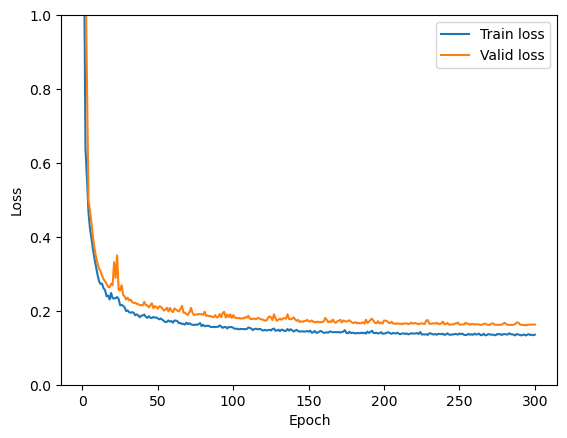

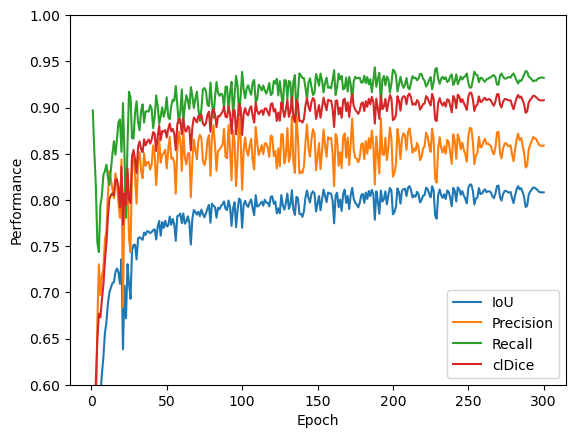

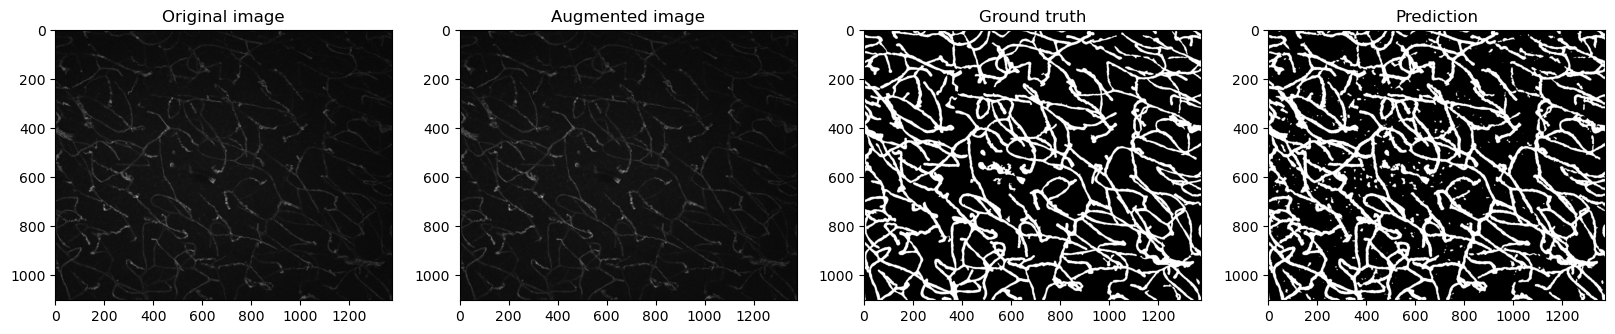

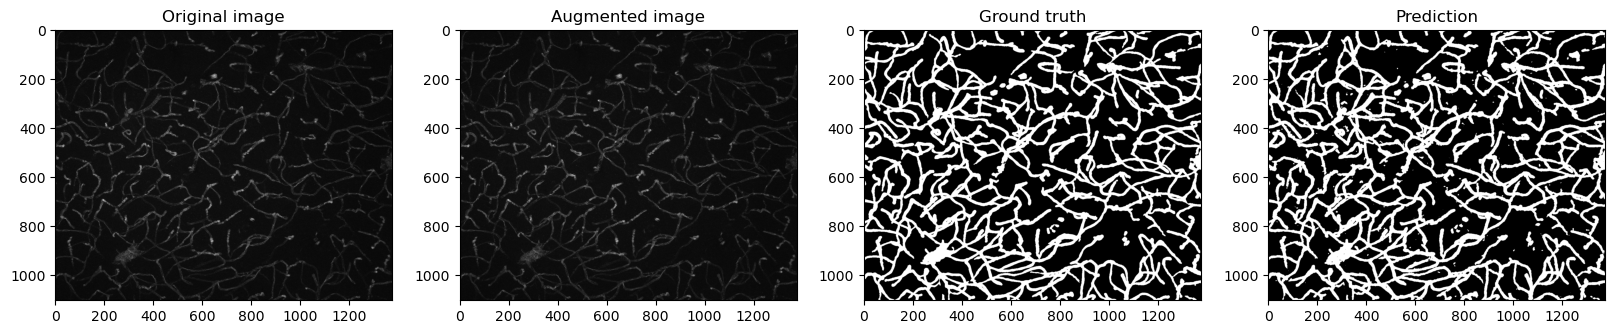

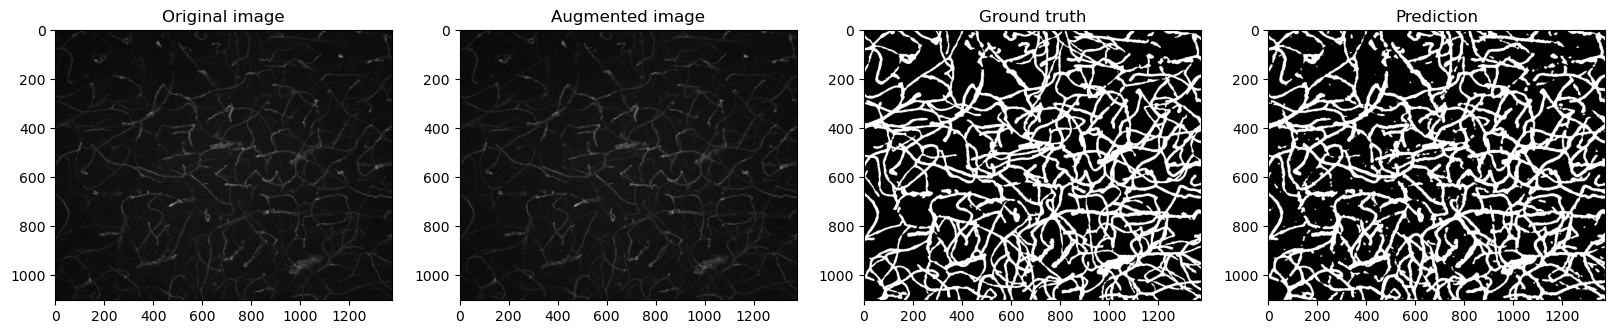

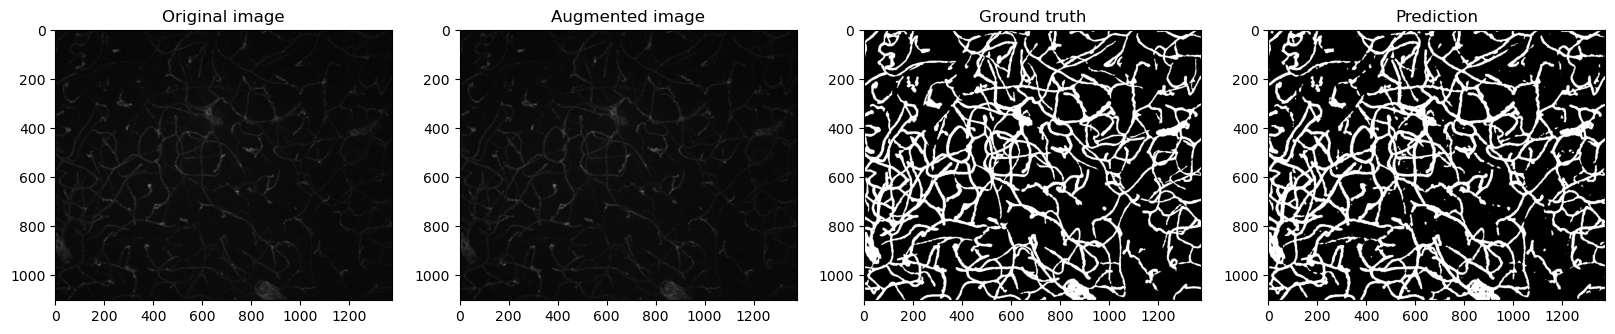

In [4]:
# Plot results
def plot_metrics(logger, type='lt'):
    '''Plot losses and IoU. `lt` is the logger used in Lightning.'''

    if type=='lt':
        metrics = logger.metrics
        epochs, _ = zip(*metrics['val_loss'])
        metrics = [list(zip(*metrics[k]))[1] for k in ['train_loss', 'val_loss', 'iou', 'prec', 
                                                       'rec', 'cldice']]
        train_loss, valid_loss, iou, prec, rec, cldice = metrics    
    elif type=='pt':
        epochs, metrics = zip(*logger.data.items())
        train_loss, valid_loss, iou, prec, rec, cldice = zip(*metrics)

    plt.figure()
    plt.plot(epochs, train_loss, label='Train loss')
    plt.plot(epochs, valid_loss, label='Valid loss')
    plt.ylim((0, 1))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.figure()
    plt.plot(epochs, iou, label='IoU')
    plt.plot(epochs, prec, label='Precision')
    plt.plot(epochs, rec, label='Recall')
    plt.plot(epochs, cldice, label='clDice')
    plt.ylim((0.6, 1))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Performance')

def plot_examples(ds, model, n=4):
    """Plot some example segmentations"""

    model.eval()
    model.cuda()
    indices = random.sample(range(len(ds)),n)
    for i, idx in enumerate(indices):
        x, y = ds[idx]
        x_or, y_or = ds.get_item(idx)
        with torch.no_grad():
            y_pred = model(x[None].cuda())[0].cpu()
        x = x[0]
        y_pred = torch.max(y_pred, dim=0)[1]

        plt.figure(figsize=[20,5])
        plt.subplot(1, 4, 1)
        plt.imshow(x_or, 'gray')
        plt.title('Original image')
        plt.subplot(1, 4, 2)
        plt.imshow(x, 'gray')
        plt.title('Augmented image')
        plt.subplot(1, 4, 3)
        plt.imshow(y, 'gray')
        plt.title('Ground truth')
        plt.subplot(1, 4, 4)
        plt.imshow(y_pred, 'gray')
        plt.title('Prediction')

plot_metrics(logger, type='pt')
plot_examples(ds_valid, model)

In [7]:
import numpy as np

keys = list(logger.data.keys())
valid_losses = [logger.data[key][1] for key in keys]
best_val_idx = keys[np.argmin(valid_losses)]

print("Best IoU | Best clDice:")
print(f"{logger.data[best_val_idx][2]} | {logger.data[best_val_idx][5]}")

print("Last IoU | Last clDice")
print(f"{logger.data[keys[-1]][2]} | {logger.data[keys[-1]][5]}")

Best IoU | Best clDice:
0.8130409121513367 | 0.9123498797416687
Last IoU | Last clDice
0.8082722425460815 | 0.9079306721687317


In [6]:
ds_train_imgs = []

for img_path in ds_train.img_file_paths:
    str_path = str(img_path)
    ds_train_imgs.append(str_path.split('/')[-1])

ds_valid_imgs = []

for img_path in ds_valid.img_file_paths:
    str_path = str(img_path)
    ds_valid_imgs.append(str_path.split('/')[-1])

print(ds_train_imgs)
print(ds_valid_imgs)

['Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@46-Image 2-20X.tiff', 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@74-Image 1-20X.tiff', 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@75-Image 4-20X.tiff', 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@64-Image 1-20X.tiff', 'T-3 Weeks@Females@391 F@391-CTL-Middle-20X-01.tiff', 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@74-Image 4-20X.tiff', 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@45-Image 1-20X.tiff', 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@75-Image 3-20X.tiff', 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@65-Image 4-20X.tiff', 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@64-Image 2-20X.tiff', 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@74-Image 3-20X.tiff', 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@59-Image 2-20X.tiff', 'Experiment #1 (adult

### 1 map

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
from original_dataset import create_datasets
import numpy as np
import os
from PIL import Image

In [2]:
import torch
import random
from engine import run

params = {
    # Dataset
    'img_dir': './data/original_images/',    # Images path
    'label_dir': './data/original_labels/',  # Labels path
    'train_val_split': 0.2,                  # Train/validation split
    'use_transforms': False,                 # Use data augmentation
    'dataset': 'artificial',
    'img_art_dir': '',
    'label_art_dir': '',
    # Model
    'model_layers': (1,1,1),                 # Number of residual blocks at each layer of the model
    'model_channels': (16,32,64),            # Number of channels at each layer
    'model_type': 'unet',                    # Model to use
    # Training
    'epochs': 100,
    'lr': 0.01,
    'batch_size_train': 8,
    'batch_size_valid': 5, 
    'momentum': 0.9,                    # Momentum for optimizer
    'weight_decay': 0.,
    'seed': 12,                         # Seed for random number generators
    'loss': 'cross_entropy',
    'scheduler_power': 0.9,             # Power por the polynomial scheduler
    'class_weights': None,              # Weights to use for cross entropy
    # Efficiency
    'device': 'cuda',
    'num_workers': 3,                   # Number of workers for the dataloader
    'use_amp': False,                   # Mixed precision
    'pin_memory': False,            
    'non_blocking': False,
    # Logging
    'log_dir': 'logs_unet',             # Directory for logging metrics and model checkpoints
    'experiment': '',                   # Experiment tag
    'save_every':1,                     # Number of epochs between checkpoints
    'save_best':True,                   # Save model with best validation loss
    'meta': None,                       # Additional metadata to save
    # Other
    'resume': False,                    # Resume from previous training
}

In [3]:
# Plot results
def plot_metrics(logger, type='lt'):
    '''Plot losses and IoU. `lt` is the logger used in Lightning.'''

    if type=='lt':
        metrics = logger.metrics
        epochs, _ = zip(*metrics['val_loss'])
        metrics = [list(zip(*metrics[k]))[1] for k in ['train_loss', 'val_loss', 'iou', 'prec', 
                                                       'rec', 'cldice']]
        train_loss, valid_loss, iou, prec, rec, cldice = metrics    
    elif type=='pt':
        epochs, metrics = zip(*logger.data.items())
        train_loss, valid_loss, iou, prec, rec, cldice = zip(*metrics)

    plt.figure()
    plt.plot(epochs, train_loss, label='Train loss')
    plt.plot(epochs, valid_loss, label='Valid loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.figure()
    plt.plot(epochs, iou, label='IoU')
    plt.plot(epochs, prec, label='Precision')
    plt.plot(epochs, rec, label='Recall')
    plt.plot(epochs, cldice, label='ClDice')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Performance')

def plot_examples(ds, model, n=4):
    """Plot some example segmentations"""

    model.eval()
    model.cuda()
    indices = random.sample(range(len(ds)),n)
    for i, idx in enumerate(indices):
        x, y = ds[idx]
        x_or, y_or = ds.get_item(idx)
        with torch.no_grad():
            y_pred = model(x[None].cuda())[0].cpu()
        x = x[0]
        y_pred = torch.max(y_pred, dim=0)[1]

        plt.figure(figsize=[20,5])
        plt.subplot(1, 4, 1)
        plt.imshow(x_or, 'gray')
        plt.title('Original image')
        plt.subplot(1, 4, 2)
        plt.imshow(x, 'gray')
        plt.title('Augmented image')
        plt.subplot(1, 4, 3)
        plt.imshow(y, 'gray')
        plt.title('Ground truth')
        plt.subplot(1, 4, 4)
        plt.imshow(y_pred, 'gray')
        plt.title('Prediction')

Pack1
0.8019585821642231 0.1980414178357769
Epoch 1/100


/home/matheus/anaconda3/envs/p3.11/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Batch 13/13, Train loss: 0.9301564693450928
Epoch finished in 7.6 seconds
Train loss: 1.4335892581939698, Valid loss: 0.7111054062843323, IoU: 0.4104067385196686, Prec: 0.5778107643127441, Rec 0.5874978303909302, clDice 0.5432296991348267
Epoch 2/100
Batch 13/13, Train loss: 0.6513497233390808
Epoch finished in 7.1 seconds
Train loss: 0.7568140149116516, Valid loss: 0.7134692072868347, IoU: 0.41031527519226074, Prec: 0.5674915909767151, Rec 0.6004813313484192, clDice 0.5330499410629272
Epoch 3/100
Batch 13/13, Train loss: 0.6386926770210266
Epoch finished in 7.0 seconds
Train loss: 0.653485176563263, Valid loss: 0.5355969071388245, IoU: 0.5138100385665894, Prec: 0.6836782693862915, Rec 0.6751538515090942, clDice 0.6472532153129578
Epoch 4/100
Batch 13/13, Train loss: 0.5101501941680908
Epoch finished in 6.9 seconds
Train loss: 0.5988658285140991, Valid loss: 0.4377495348453522, IoU: 0.5798728466033936, Prec: 0.6897166967391968, Rec 0.785351574420929, clDice 0.7017119526863098
Epoch 5/1

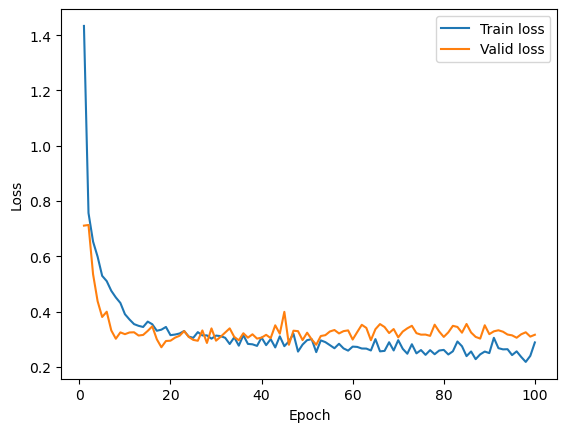

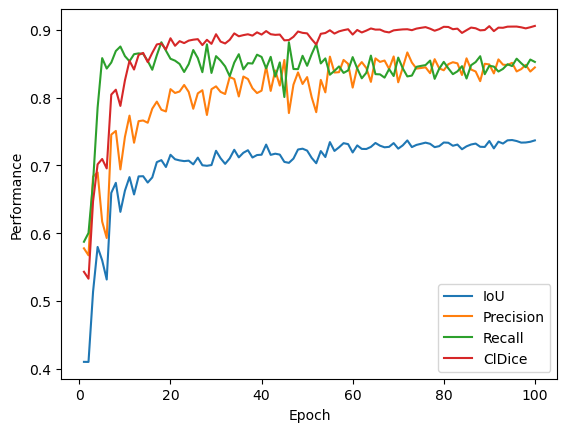

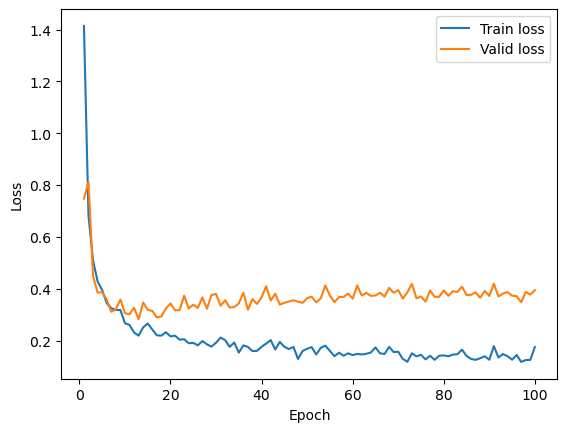

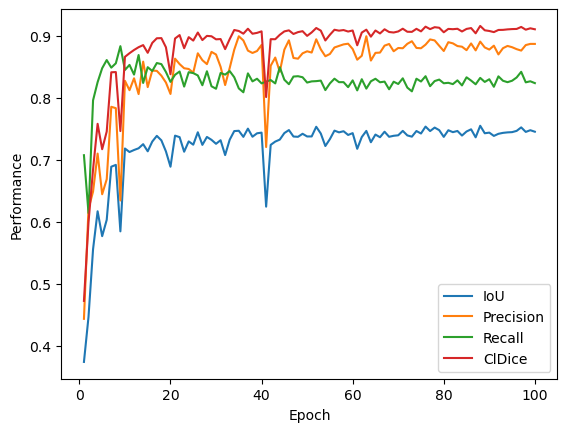

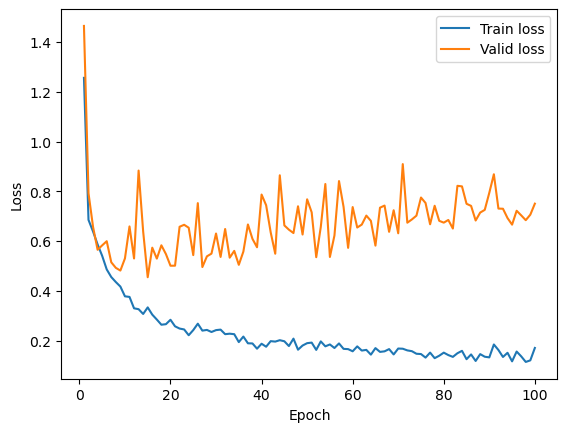

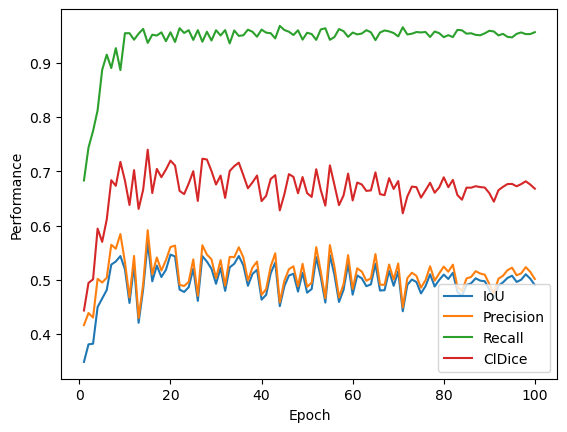

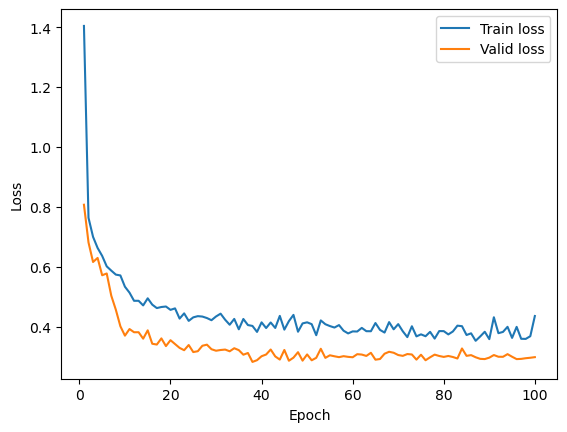

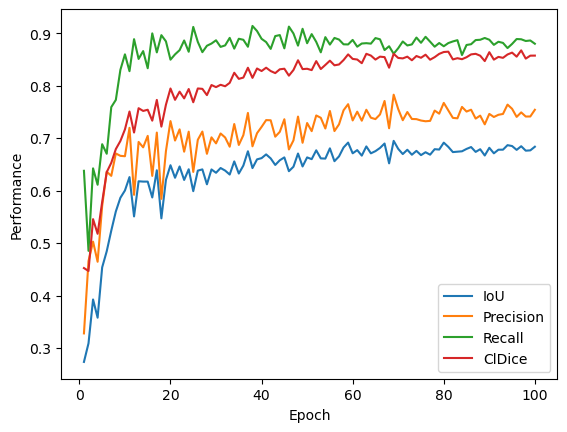

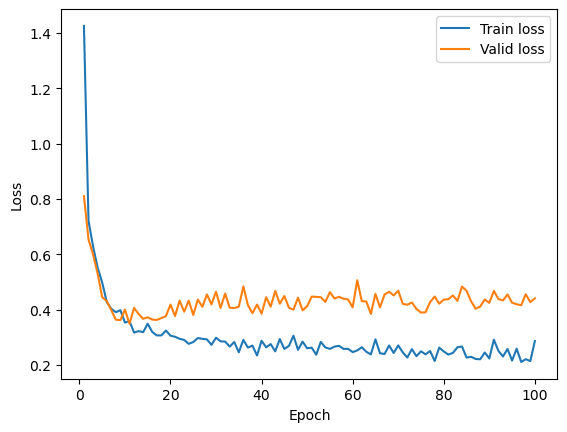

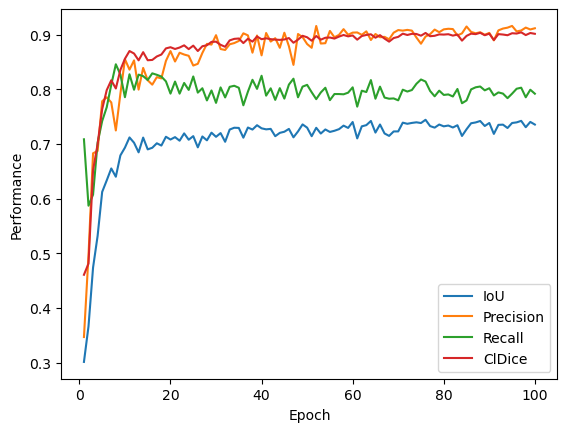

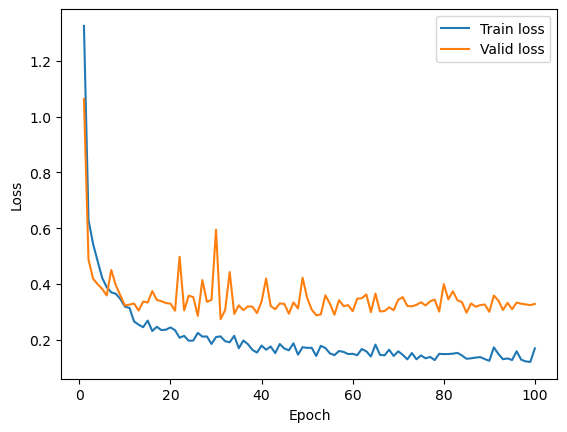

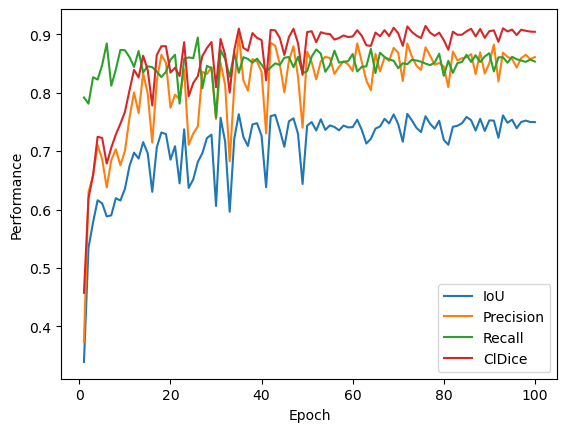

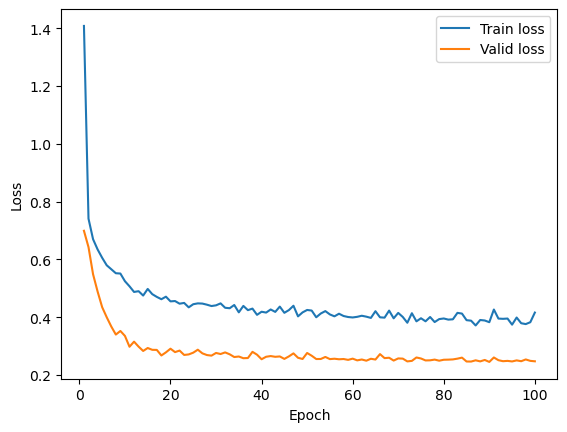

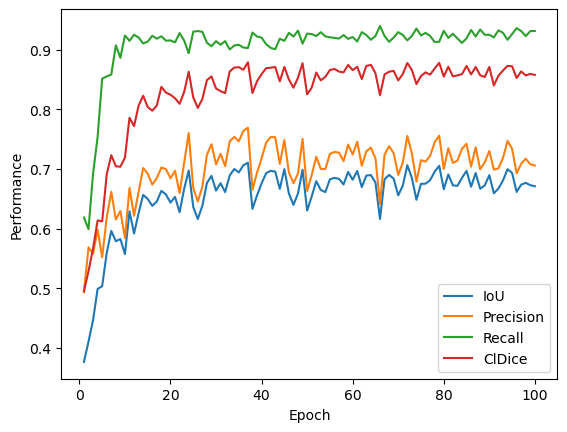

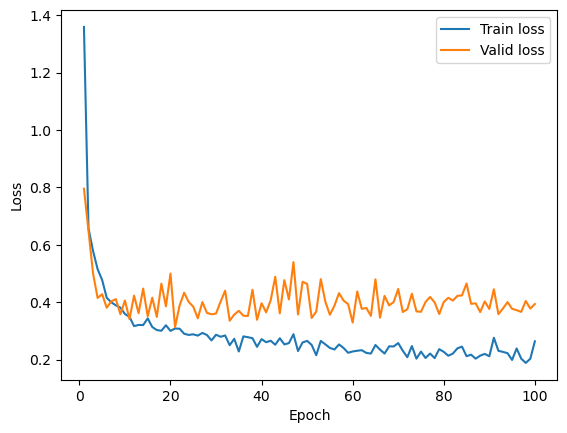

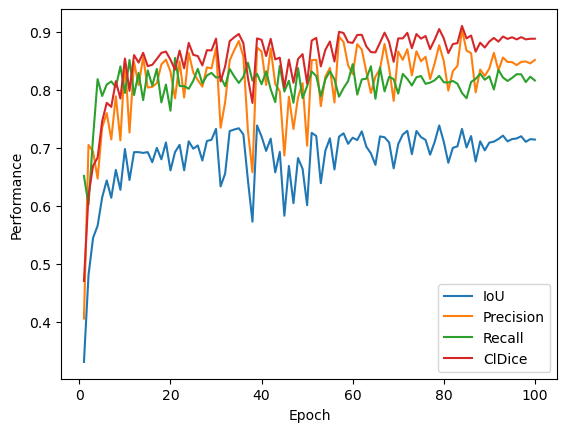

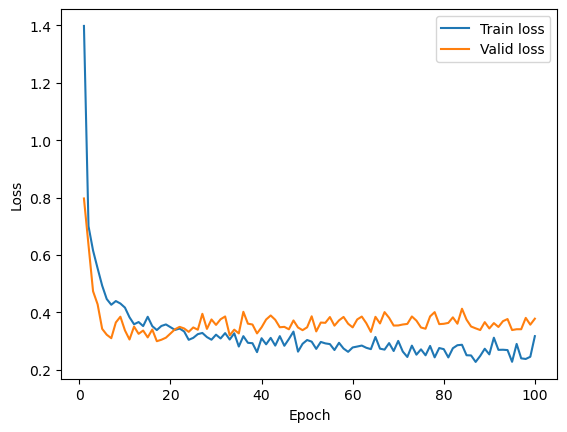

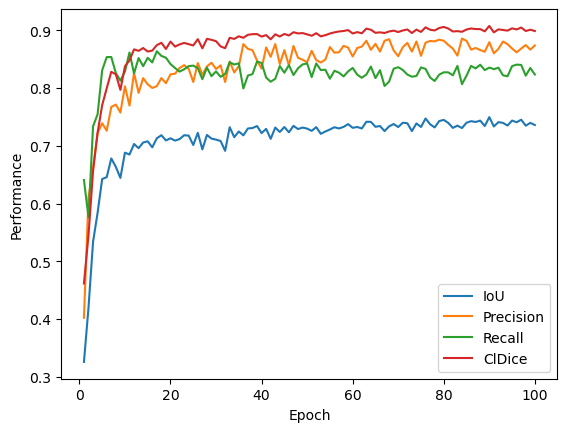

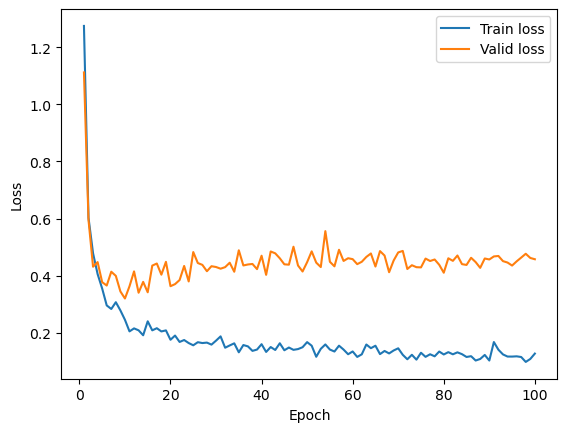

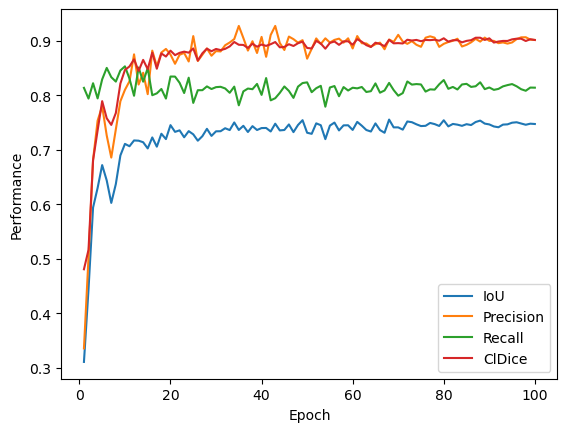

In [4]:
def get_dataset_stats(label_dir):
    count_foreground = 0
    total_pixels = 0
    for fname in os.listdir(label_dir):
        img = np.asarray(Image.open(f'{label_dir}/{fname}'))
        count_foreground += np.count_nonzero(img)
        total_pixels += img.shape[0]*img.shape[1]
    
    pct_foreground = count_foreground/total_pixels

    return 1-pct_foreground, pct_foreground        

last_ious = []
last_cldices = []
best_ious = []
best_cldices = []
for i in range(1, 11):
    print(f'Pack{i}')
    params['img_art_dir']   = f'./data/Generated_from_1_map/pack{i}/images'
    params['label_art_dir'] = f'./data/Generated_from_1_map/pack{i}/labels'
    params['experiment'] = f'1label_pack{i}'
    pct_background, pct_foreground = get_dataset_stats(params['label_art_dir'])
    params['class_weights'] = (pct_foreground, pct_background)

    print(pct_background, pct_foreground)

    logger, _, _, _ = run(params)

    valid_losses_from_exp = [logger.data[key][1] for key in logger.data.keys()]

    # stats of epoch with best valid loss
    best_vl_key = list(logger.data.keys())[np.argmin(valid_losses_from_exp)]
    best_ious.append(logger.data[best_vl_key][2])
    best_cldices.append(logger.data[best_vl_key][5])

    # stats of last epoch
    last_key = list(logger.data.keys())[-1]
    last_ious.append(logger.data[last_key][2])
    last_cldices.append(logger.data[last_key][5])

    plot_metrics(logger, 'pt')

print(f'(BEST)\n'
      f'Average IoU: {np.mean(best_ious)}, IoU std: {np.std(best_ious)}\n'
      f'Average clDice: {np.mean(best_cldices)}, clDice std: {np.std(best_cldices)}\n')

print(f'(LAST)\n'
      f'Average IoU: {np.mean(last_ious)}, IoU std: {np.std(last_ious)}\n'
      f'Average clDice: {np.mean(last_cldices)}, clDice std: {np.std(last_cldices)}')

### 5 maps

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
from original_dataset import create_datasets
import numpy as np
import os
from PIL import Image

In [2]:
import torch
import random
from engine import run

params = {
    # Dataset
    'img_dir': './data/original_images/',    # Images path
    'label_dir': './data/original_labels/',  # Labels path
    'train_val_split': 0.2,                  # Train/validation split
    'use_transforms': False,                 # Use data augmentation
    'dataset': 'artificial',
    'img_art_dir': '',
    'label_art_dir': '',
    # Model
    'model_layers': (1,1,1),                 # Number of residual blocks at each layer of the model
    'model_channels': (16,32,64),            # Number of channels at each layer
    'model_type': 'unet',                    # Model to use
    # Training
    'epochs': 100,
    'lr': 0.01,
    'batch_size_train': 8,
    'batch_size_valid': 5, 
    'momentum': 0.9,                    # Momentum for optimizer
    'weight_decay': 0.,
    'seed': 12,                         # Seed for random number generators
    'loss': 'cross_entropy',
    'scheduler_power': 0.9,             # Power por the polynomial scheduler
    'class_weights': None,              # Weights to use for cross entropy
    # Efficiency
    'device': 'cuda',
    'num_workers': 3,                   # Number of workers for the dataloader
    'use_amp': False,                   # Mixed precision
    'pin_memory': False,            
    'non_blocking': False,
    # Logging
    'log_dir': 'logs_unet',             # Directory for logging metrics and model checkpoints
    'experiment': '',                   # Experiment tag
    'save_every':1,                     # Number of epochs between checkpoints
    'save_best':True,                   # Save model with best validation loss
    'meta': None,                       # Additional metadata to save
    # Other
    'resume': False,                    # Resume from previous training
}

In [3]:
# Plot results
def plot_metrics(logger, type='lt'):
    '''Plot losses and IoU. `lt` is the logger used in Lightning.'''

    if type=='lt':
        metrics = logger.metrics
        epochs, _ = zip(*metrics['val_loss'])
        metrics = [list(zip(*metrics[k]))[1] for k in ['train_loss', 'val_loss', 'iou', 'prec', 
                                                       'rec', 'cldice']]
        train_loss, valid_loss, iou, prec, rec, cldice = metrics    
    elif type=='pt':
        epochs, metrics = zip(*logger.data.items())
        train_loss, valid_loss, iou, prec, rec, cldice = zip(*metrics)

    plt.figure()
    plt.plot(epochs, train_loss, label='Train loss')
    plt.plot(epochs, valid_loss, label='Valid loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.figure()
    plt.plot(epochs, iou, label='IoU')
    plt.plot(epochs, prec, label='Precision')
    plt.plot(epochs, rec, label='Recall')
    plt.plot(epochs, cldice, label='ClDice')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Performance')

def plot_examples(ds, model, n=4):
    """Plot some example segmentations"""

    model.eval()
    model.cuda()
    indices = random.sample(range(len(ds)),n)
    for i, idx in enumerate(indices):
        x, y = ds[idx]
        x_or, y_or = ds.get_item(idx)
        with torch.no_grad():
            y_pred = model(x[None].cuda())[0].cpu()
        x = x[0]
        y_pred = torch.max(y_pred, dim=0)[1]

        plt.figure(figsize=[20,5])
        plt.subplot(1, 4, 1)
        plt.imshow(x_or, 'gray')
        plt.title('Original image')
        plt.subplot(1, 4, 2)
        plt.imshow(x, 'gray')
        plt.title('Augmented image')
        plt.subplot(1, 4, 3)
        plt.imshow(y, 'gray')
        plt.title('Ground truth')
        plt.subplot(1, 4, 4)
        plt.imshow(y_pred, 'gray')
        plt.title('Prediction')

Pack1
0.8557171266746714 0.1442828733253286
Epoch 1/100


/home/matheus/anaconda3/envs/p3.11/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Batch 13/13, Train loss: 0.8946523666381836
Epoch finished in 8.1 seconds
Train loss: 1.4208499383926392, Valid loss: 0.7680293321609497, IoU: 0.32678624987602234, Prec: 0.42329683899879456, Rec 0.5979467630386353, clDice 0.45387083292007446
Epoch 2/100
Batch 13/13, Train loss: 0.6634451746940613
Epoch finished in 7.0 seconds
Train loss: 0.7274281859397889, Valid loss: 0.6360059976577759, IoU: 0.39967700839042664, Prec: 0.6082128882408142, Rec 0.5414489507675171, clDice 0.5289992094039917
Epoch 3/100
Batch 13/13, Train loss: 0.6487163305282593
Epoch finished in 7.0 seconds
Train loss: 0.6705907678604126, Valid loss: 0.5883022546768188, IoU: 0.45144596695899963, Prec: 0.6706257462501526, Rec 0.5796084403991699, clDice 0.6015453934669495
Epoch 4/100
Batch 13/13, Train loss: 0.5189200043678284
Epoch finished in 6.9 seconds
Train loss: 0.6034524512290954, Valid loss: 0.5018694400787354, IoU: 0.5437729358673096, Prec: 0.7000142335891724, Rec 0.7086457014083862, clDice 0.685258686542511
Epoc

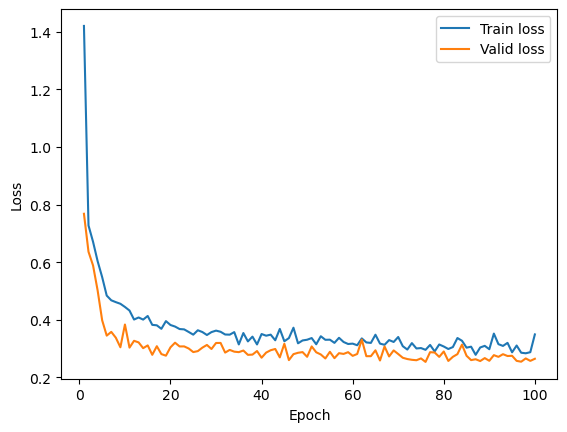

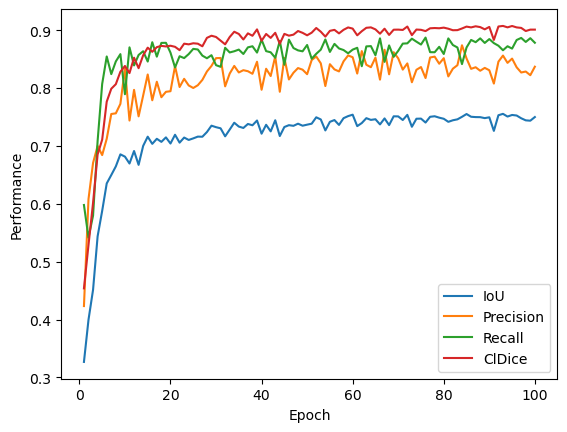

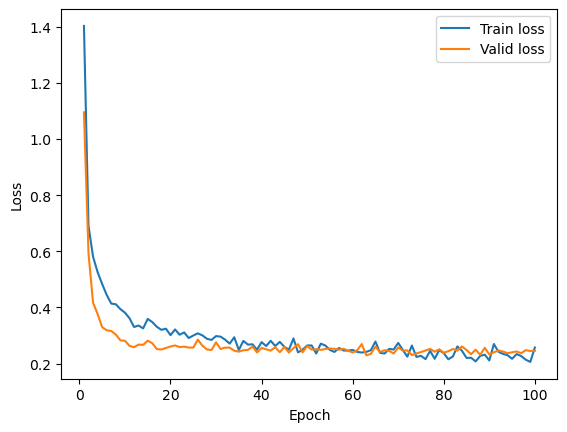

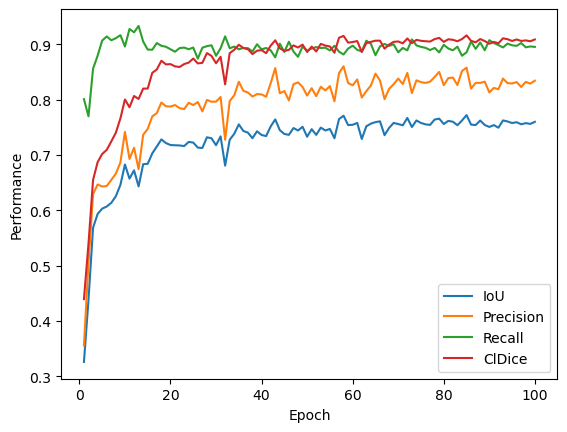

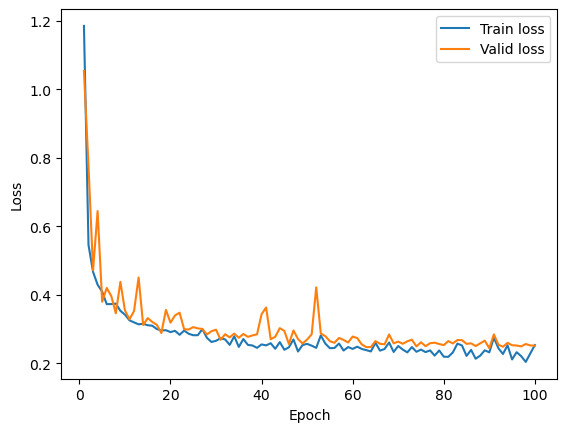

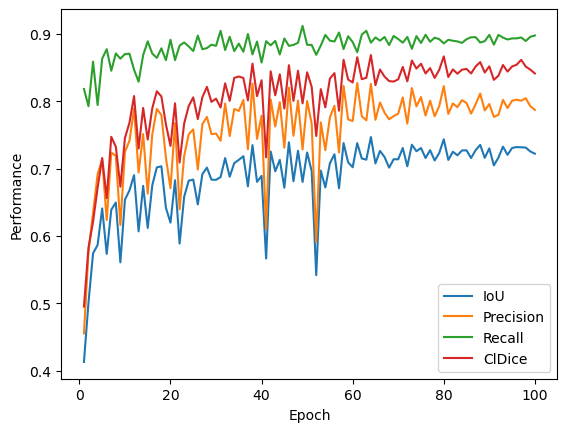

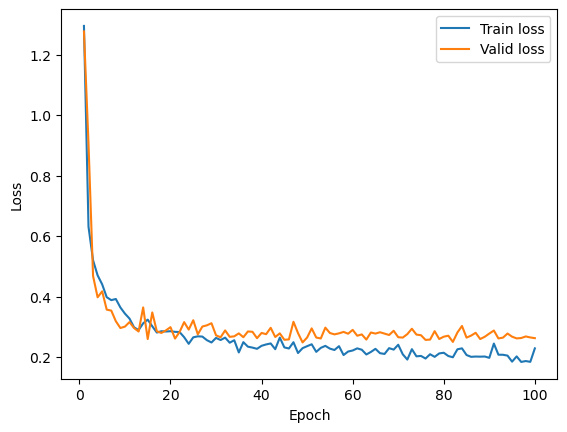

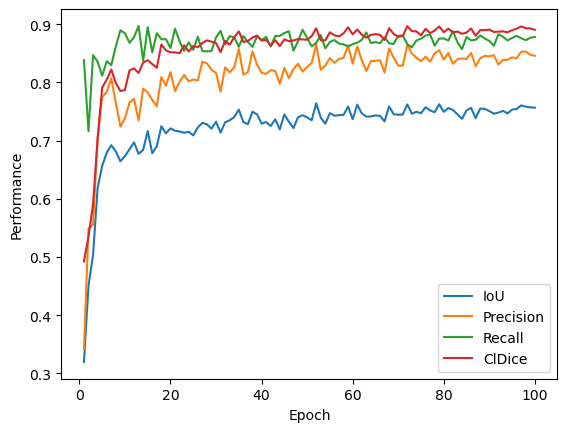

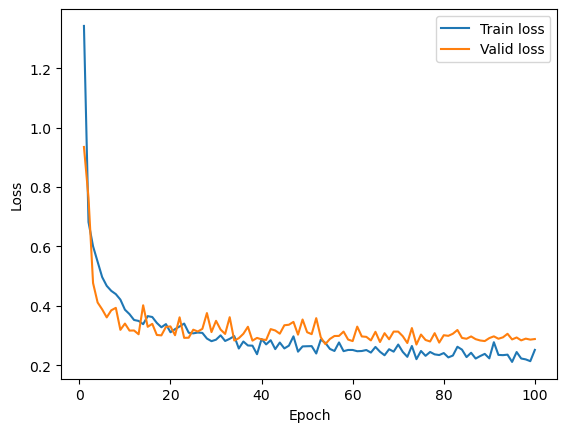

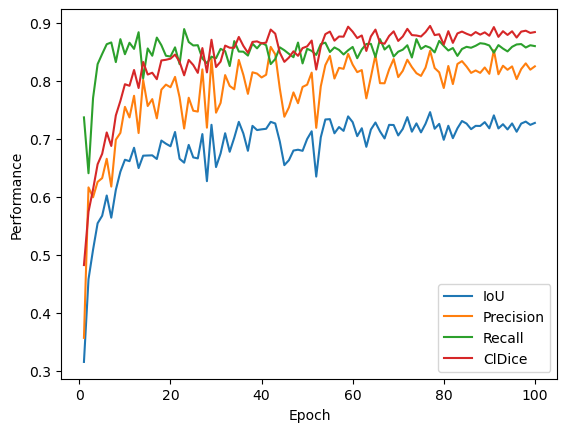

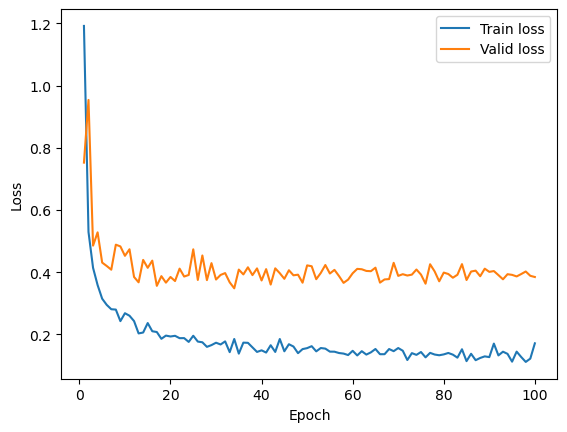

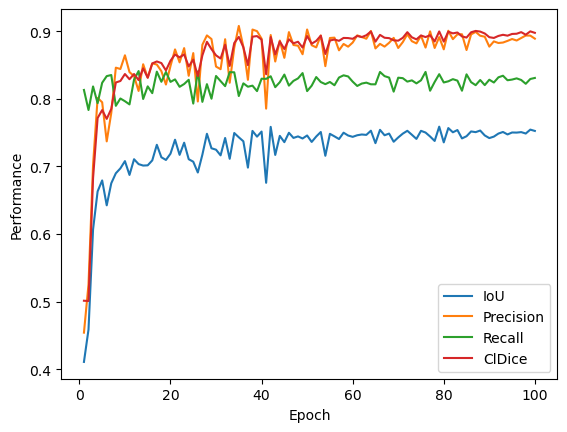

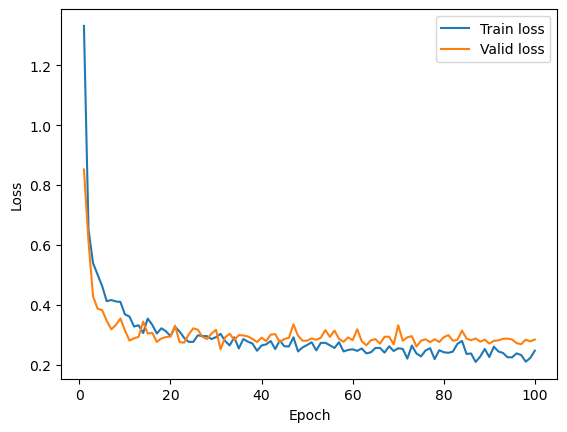

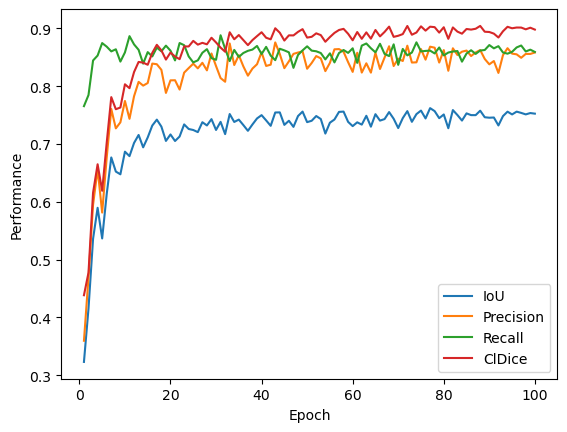

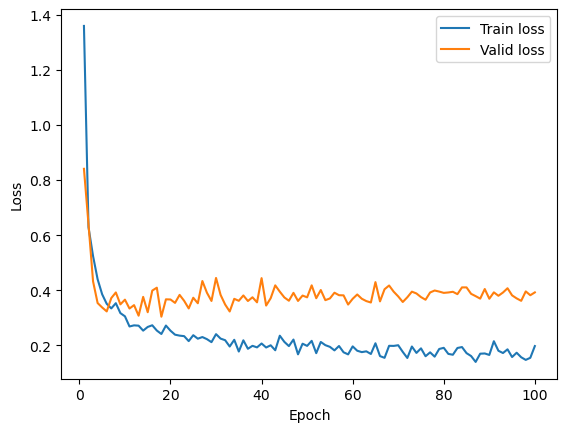

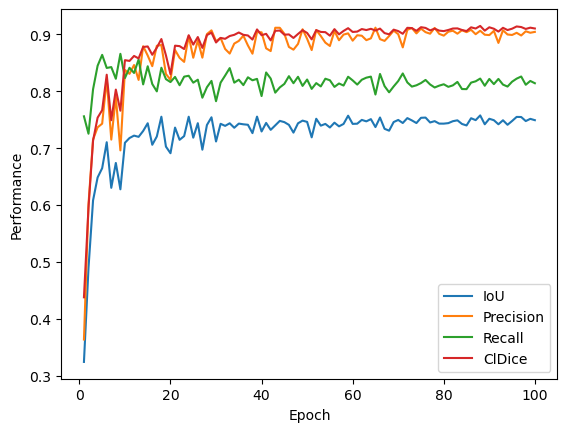

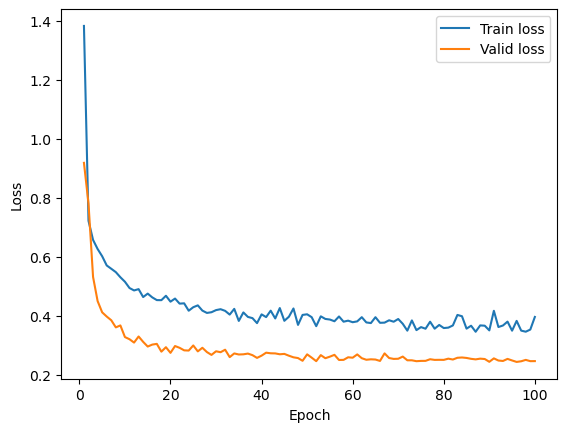

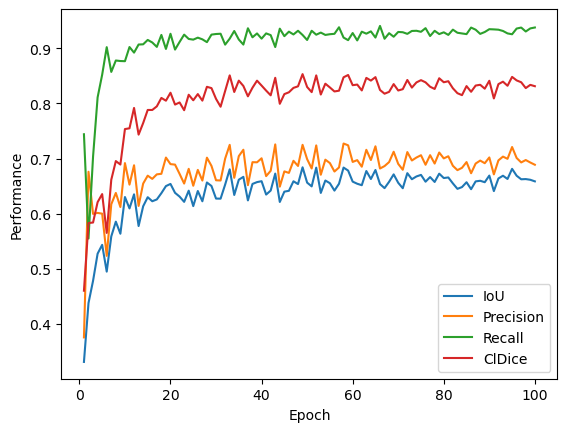

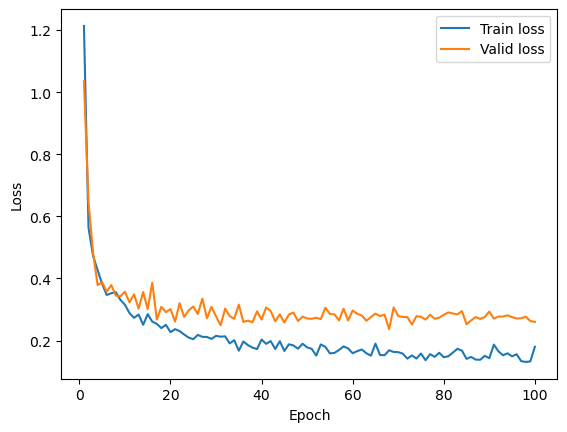

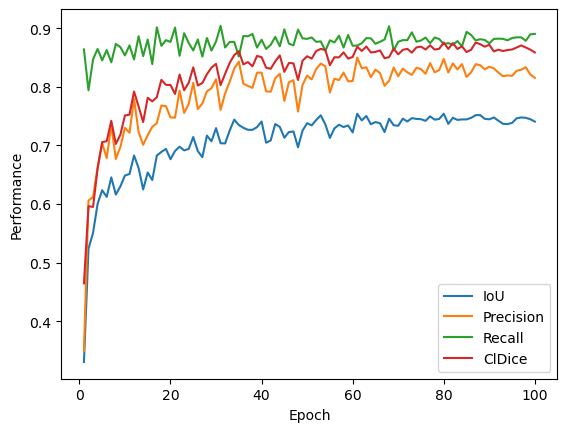

In [4]:
def get_dataset_stats(label_dir):
    count_foreground = 0
    total_pixels = 0
    for fname in os.listdir(label_dir):
        img = np.asarray(Image.open(f'{label_dir}/{fname}'))
        count_foreground += np.count_nonzero(img)
        total_pixels += img.shape[0]*img.shape[1]
    
    pct_foreground = count_foreground/total_pixels

    return 1-pct_foreground, pct_foreground        

last_ious = []
last_cldices = []
best_ious = []
best_cldices = []
for i in range(1, 11):
    print(f'Pack{i}')
    params['img_art_dir']   = f'./data/Generated_from_5_maps/pack{i}/images'
    params['label_art_dir'] = f'./data/Generated_from_5_maps/pack{i}/labels'
    params['experiment'] = f'1label_pack{i}'
    pct_background, pct_foreground = get_dataset_stats(params['label_art_dir'])
    params['class_weights'] = (pct_foreground, pct_background)

    print(pct_background, pct_foreground)

    logger, _, _, _ = run(params)

    valid_losses_from_exp = [logger.data[key][1] for key in logger.data.keys()]

    # stats of epoch with best valid loss
    best_vl_key = list(logger.data.keys())[np.argmin(valid_losses_from_exp)]
    best_ious.append(logger.data[best_vl_key][2])
    best_cldices.append(logger.data[best_vl_key][5])

    # stats of last epoch
    last_key = list(logger.data.keys())[-1]
    last_ious.append(logger.data[last_key][2])
    last_cldices.append(logger.data[last_key][5])

    plot_metrics(logger, 'pt')

print(f'(BEST)\n'
      f'Average IoU: {np.mean(best_ious)}, IoU std: {np.std(best_ious)}\n'
      f'Average clDice: {np.mean(best_cldices)}, clDice std: {np.std(best_cldices)}\n')

print(f'(LAST)\n'
      f'Average IoU: {np.mean(last_ious)}, IoU std: {np.std(last_ious)}\n'
      f'Average clDice: {np.mean(last_cldices)}, clDice std: {np.std(last_cldices)}')

### 10 maps

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
from original_dataset import create_datasets
import numpy as np
import os
from PIL import Image

In [2]:
import torch
import random
from engine import run

params = {
    # Dataset
    'img_dir': './data/original_images/',    # Images path
    'label_dir': './data/original_labels/',  # Labels path
    'train_val_split': 0.2,                  # Train/validation split
    'use_transforms': False,                 # Use data augmentation
    'dataset': 'artificial',
    'img_art_dir': '',
    'label_art_dir': '',
    # Model
    'model_layers': (1,1,1),                 # Number of residual blocks at each layer of the model
    'model_channels': (16,32,64),            # Number of channels at each layer
    'model_type': 'unet',                    # Model to use
    # Training
    'epochs': 100,
    'lr': 0.01,
    'batch_size_train': 8,
    'batch_size_valid': 5, 
    'momentum': 0.9,                    # Momentum for optimizer
    'weight_decay': 0.,
    'seed': 12,                         # Seed for random number generators
    'loss': 'cross_entropy',
    'scheduler_power': 0.9,             # Power por the polynomial scheduler
    'class_weights': None,              # Weights to use for cross entropy
    # Efficiency
    'device': 'cuda',
    'num_workers': 3,                   # Number of workers for the dataloader
    'use_amp': False,                   # Mixed precision
    'pin_memory': False,            
    'non_blocking': False,
    # Logging
    'log_dir': 'logs_unet',             # Directory for logging metrics and model checkpoints
    'experiment': '',                   # Experiment tag
    'save_every':1,                     # Number of epochs between checkpoints
    'save_best':True,                   # Save model with best validation loss
    'meta': None,                       # Additional metadata to save
    # Other
    'resume': False,                    # Resume from previous training
}

In [3]:
# Plot results
def plot_metrics(logger, type='lt'):
    '''Plot losses and IoU. `lt` is the logger used in Lightning.'''

    if type=='lt':
        metrics = logger.metrics
        epochs, _ = zip(*metrics['val_loss'])
        metrics = [list(zip(*metrics[k]))[1] for k in ['train_loss', 'val_loss', 'iou', 'prec', 
                                                       'rec', 'cldice']]
        train_loss, valid_loss, iou, prec, rec, cldice = metrics    
    elif type=='pt':
        epochs, metrics = zip(*logger.data.items())
        train_loss, valid_loss, iou, prec, rec, cldice = zip(*metrics)

    plt.figure()
    plt.plot(epochs, train_loss, label='Train loss')
    plt.plot(epochs, valid_loss, label='Valid loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.figure()
    plt.plot(epochs, iou, label='IoU')
    plt.plot(epochs, prec, label='Precision')
    plt.plot(epochs, rec, label='Recall')
    plt.plot(epochs, cldice, label='ClDice')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Performance')

def plot_examples(ds, model, n=4):
    """Plot some example segmentations"""

    model.eval()
    model.cuda()
    indices = random.sample(range(len(ds)),n)
    for i, idx in enumerate(indices):
        x, y = ds[idx]
        x_or, y_or = ds.get_item(idx)
        with torch.no_grad():
            y_pred = model(x[None].cuda())[0].cpu()
        x = x[0]
        y_pred = torch.max(y_pred, dim=0)[1]

        plt.figure(figsize=[20,5])
        plt.subplot(1, 4, 1)
        plt.imshow(x_or, 'gray')
        plt.title('Original image')
        plt.subplot(1, 4, 2)
        plt.imshow(x, 'gray')
        plt.title('Augmented image')
        plt.subplot(1, 4, 3)
        plt.imshow(y, 'gray')
        plt.title('Ground truth')
        plt.subplot(1, 4, 4)
        plt.imshow(y_pred, 'gray')
        plt.title('Prediction')

Pack1
0.8296906597573306 0.17030934024266936
Epoch 1/100


/home/matheus/anaconda3/envs/p3.11/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Batch 13/13, Train loss: 0.8426569700241089
Epoch finished in 8.8 seconds
Train loss: 1.388651647567749, Valid loss: 0.806459903717041, IoU: 0.34490522742271423, Prec: 0.424518883228302, Rec 0.6546142101287842, clDice 0.4540826380252838
Epoch 2/100
Batch 13/13, Train loss: 0.6560130119323731
Epoch finished in 7.3 seconds
Train loss: 0.7015468406677247, Valid loss: 0.6183580160140991, IoU: 0.4217613637447357, Prec: 0.5482130646705627, Rec 0.6463150978088379, clDice 0.5492278933525085
Epoch 3/100
Batch 13/13, Train loss: 0.6321438550949097
Epoch finished in 7.1 seconds
Train loss: 0.6202572298049926, Valid loss: 0.4950934946537018, IoU: 0.5264372825622559, Prec: 0.6413278579711914, Rec 0.7465861439704895, clDice 0.6494590640068054
Epoch 4/100
Batch 13/13, Train loss: 0.5373599529266357
Epoch finished in 7.1 seconds
Train loss: 0.5738108015060425, Valid loss: 0.4304984211921692, IoU: 0.5471912622451782, Prec: 0.6194432973861694, Rec 0.8263780474662781, clDice 0.6637755632400513
Epoch 5/10

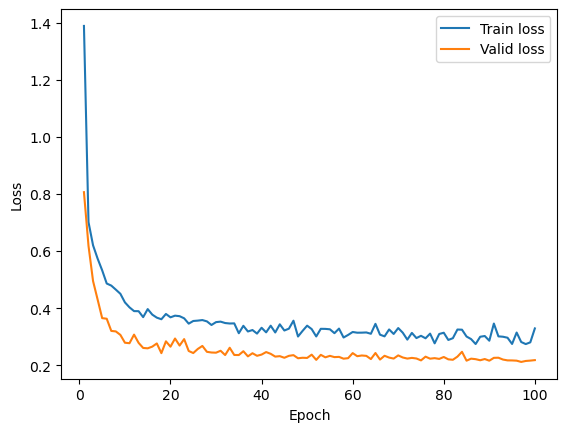

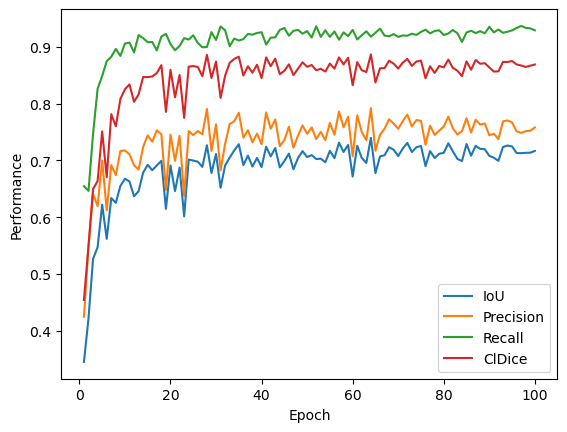

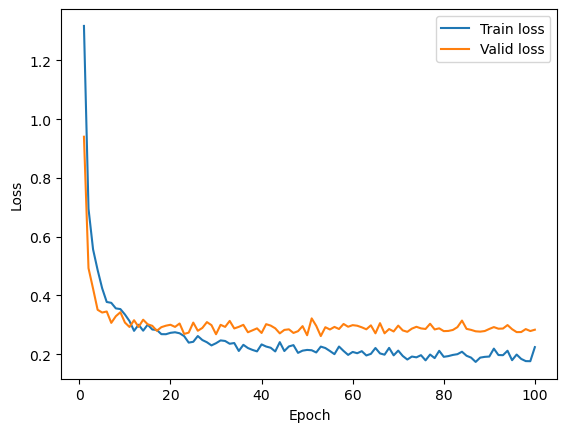

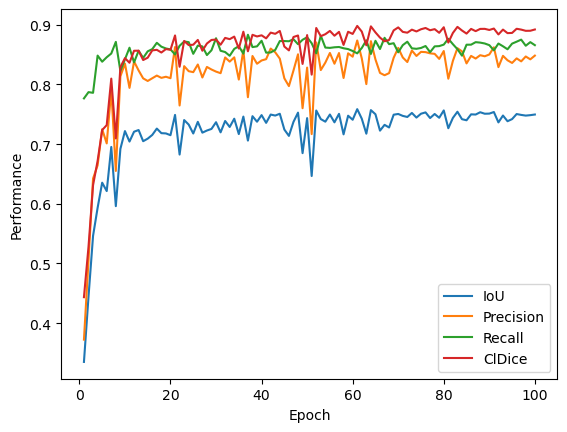

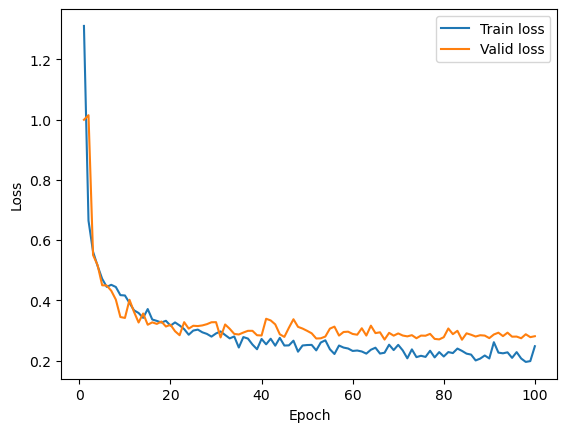

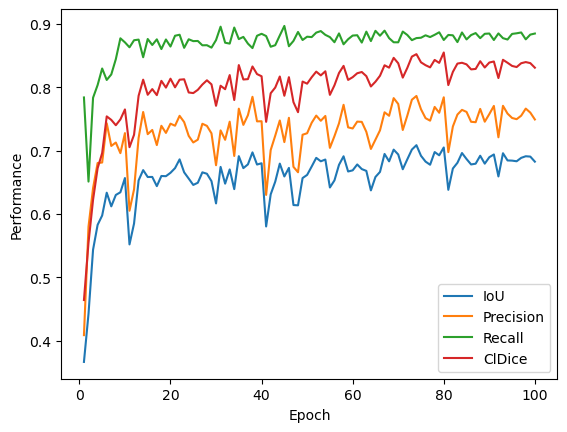

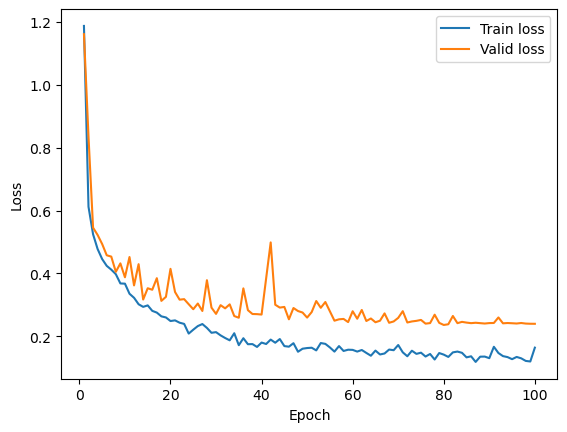

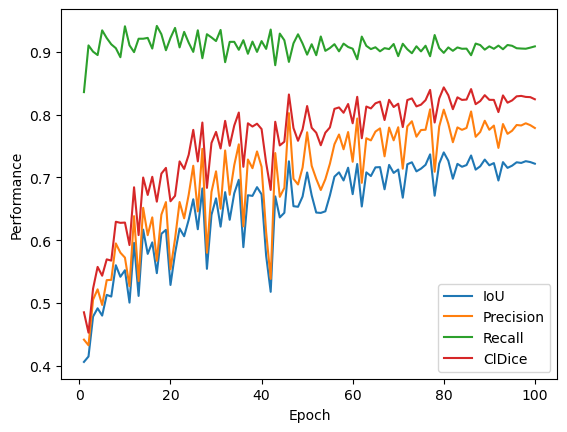

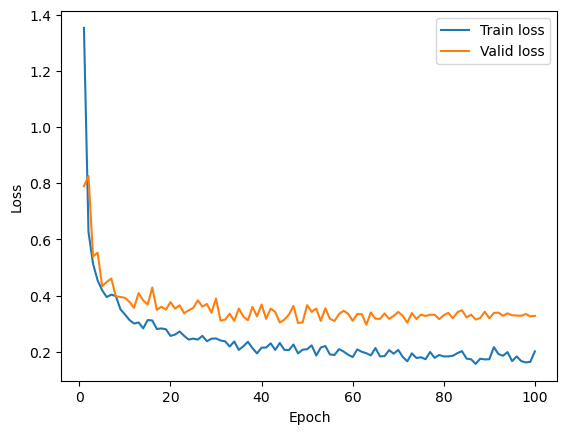

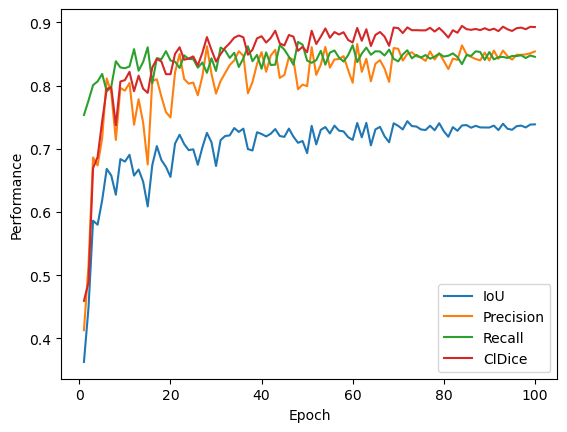

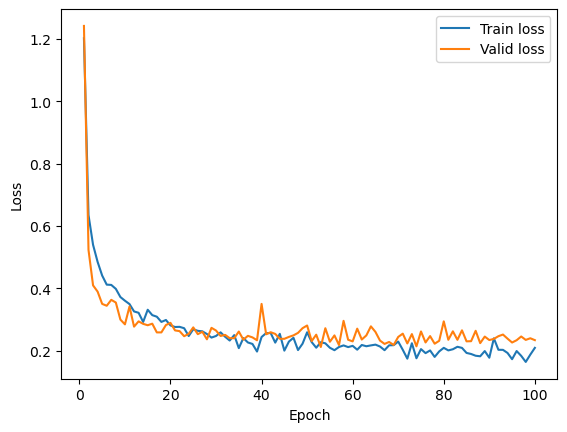

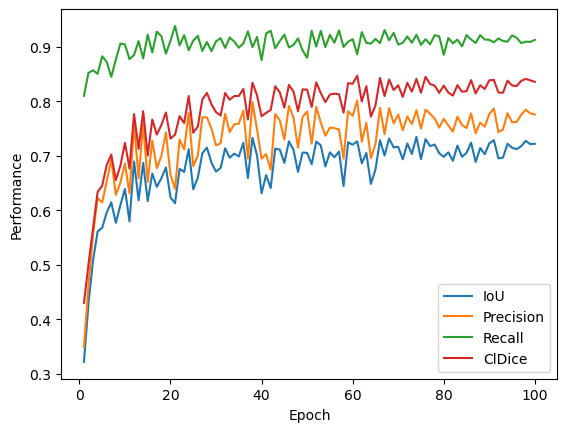

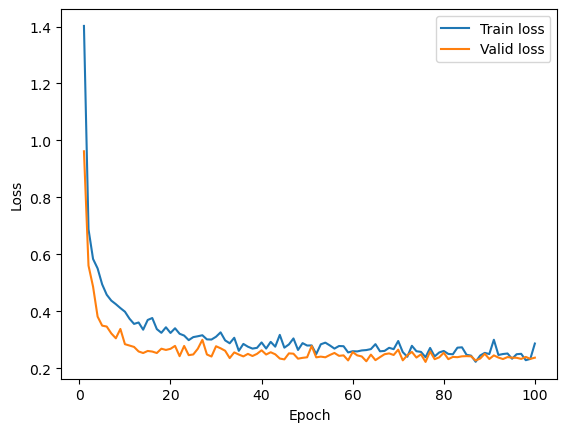

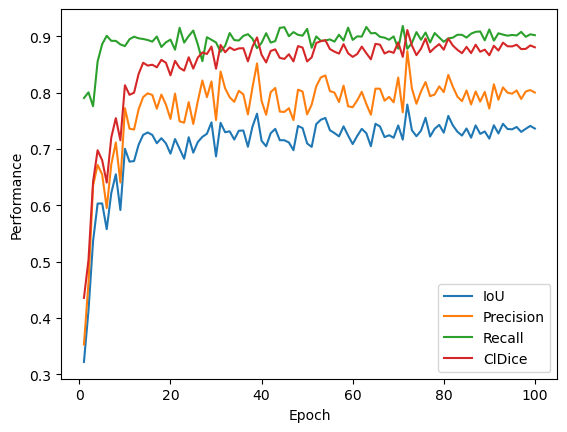

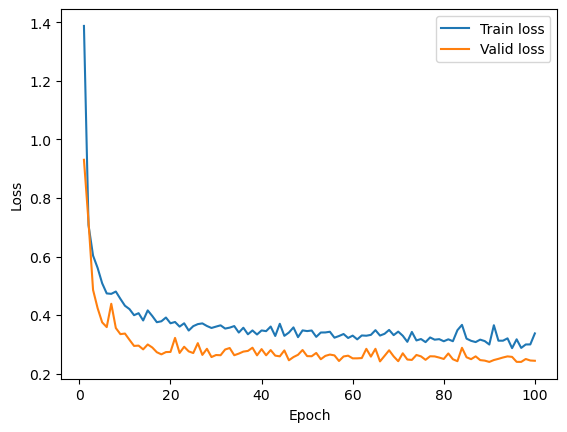

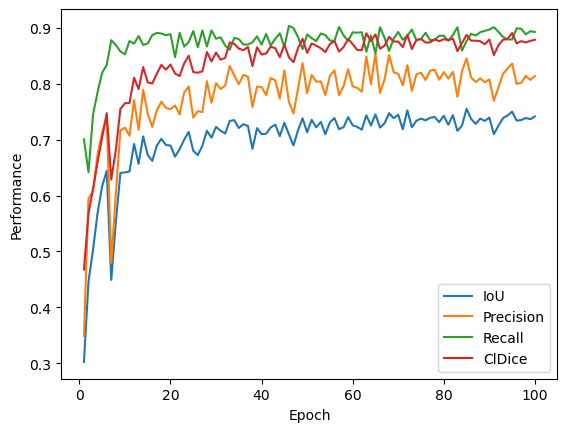

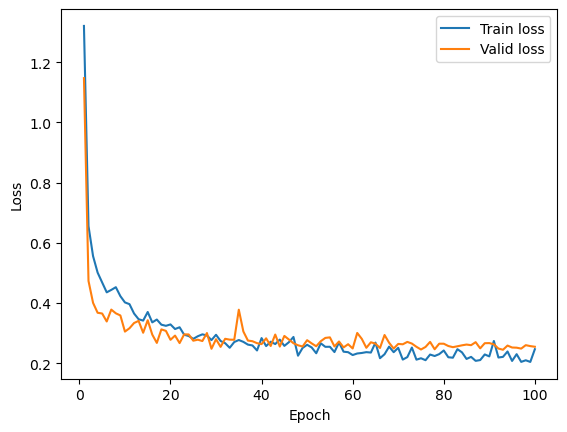

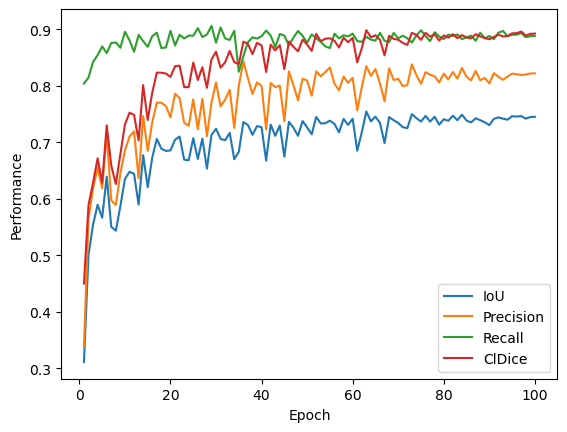

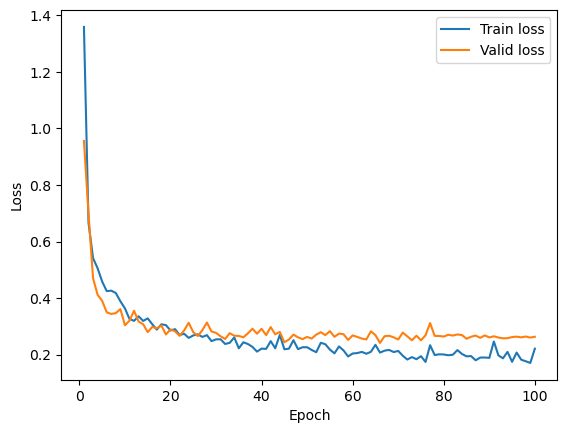

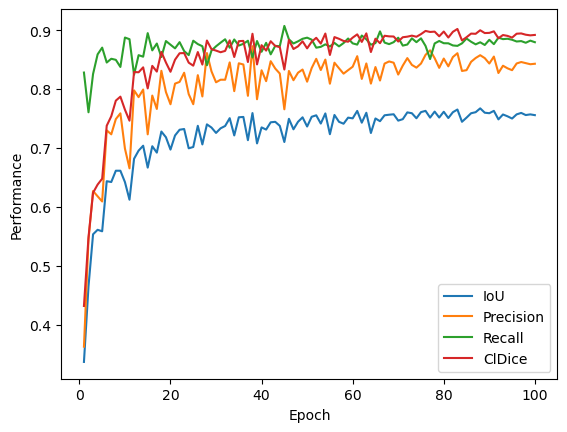

In [4]:
def get_dataset_stats(label_dir):
    count_foreground = 0
    total_pixels = 0
    for fname in os.listdir(label_dir):
        img = np.asarray(Image.open(f'{label_dir}/{fname}'))
        count_foreground += np.count_nonzero(img)
        total_pixels += img.shape[0]*img.shape[1]
    
    pct_foreground = count_foreground/total_pixels

    return 1-pct_foreground, pct_foreground        

last_ious = []
last_cldices = []
best_ious = []
best_cldices = []
for i in range(1, 11):
    print(f'Pack{i}')
    params['img_art_dir']   = f'./data/Generated_from_10_maps/pack{i}/images'
    params['label_art_dir'] = f'./data/Generated_from_10_maps/pack{i}/labels'
    params['experiment'] = f'10label_pack{i}'
    pct_background, pct_foreground = get_dataset_stats(params['label_art_dir'])
    params['class_weights'] = (pct_foreground, pct_background)

    print(pct_background, pct_foreground)

    logger, _, _, _ = run(params)

    valid_losses_from_exp = [logger.data[key][1] for key in logger.data.keys()]

    # stats of epoch with best valid loss
    best_vl_key = list(logger.data.keys())[np.argmin(valid_losses_from_exp)]
    best_ious.append(logger.data[best_vl_key][2])
    best_cldices.append(logger.data[best_vl_key][5])

    # stats of last epoch
    last_key = list(logger.data.keys())[-1]
    last_ious.append(logger.data[last_key][2])
    last_cldices.append(logger.data[last_key][5])

    plot_metrics(logger, 'pt')

print(f'(BEST)\n'
      f'Average IoU: {np.mean(best_ious)}, IoU std: {np.std(best_ious)}\n'
      f'Average clDice: {np.mean(best_cldices)}, clDice std: {np.std(best_cldices)}\n')

print(f'(LAST)\n'
      f'Average IoU: {np.mean(last_ious)}, IoU std: {np.std(last_ious)}\n'
      f'Average clDice: {np.mean(last_cldices)}, clDice std: {np.std(last_cldices)}')

In [18]:
path = './data/Generated_from_10_maps/'
packs = np.arange(1, 11, 1)
for pack in packs:
    imgs = os.listdir(f'{path}/pack{pack}/images')
    labels = os.listdir(f'{path}/pack{pack}/labels')
    for label in labels:
        if label not in imgs:
            print(f'Pack {pack}. Label: {label} not in images folder!')

    for img in imgs:
        if img not in labels:
            print(f'Pack {pack}. Image: {img} not in labels folder!')

Pack 1. Label: Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@60-Image 2-20X_0_com_40_label.tiff not in images folder!
Pack 1. Image: Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@60-Image 2-20X_0_com_40.tiff not in labels folder!


### 160 maps

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
from original_dataset import create_datasets

In [3]:
import torch
import random
from engine import run

params = {
    # Dataset
    'img_dir': './data/original_images',                    # Images path
    'label_dir': './data/original_labels/',                  # Labels path
    'train_val_split': 0.2,             # Train/validation split
    'use_transforms': False,            # Use data augmentation
    'dataset': 'artificial',
    'img_art_dir': './data/Generated_from_160_maps/images',
    'label_art_dir': './data/Generated_from_160_maps/labels',
    # Model
    'model_layers': (1,1,1),          # Number of residual blocks at each layer of the model
    'model_channels': (16,32,64),       # Number of channels at each layer
    'model_type': 'unet',               # Model to use
    # Training
    'epochs': 100,
    'lr': 0.01,
    'batch_size_train': 8,
    'batch_size_valid': 5, 
    'momentum': 0.9,                    # Momentum for optimizer
    'weight_decay': 0.,
    'seed': 12,                         # Seed for random number generators
    'loss': 'cross_entropy',
    'scheduler_power': 0.9,             # Power por the polynomial scheduler
    'class_weights': (0.1596, 0.8403),  # Weights to use for cross entropy
    # Efficiency
    'device': 'cuda',
    'num_workers': 3,                   # Number of workers for the dataloader
    'use_amp': True,                    # Mixed precision
    'pin_memory': False,            
    'non_blocking': False,
    # Logging
    'log_dir': 'logs_unet',             # Directory for logging metrics and model checkpoints
    'experiment':'160maps',             # Experiment tag
    'save_every':1,                     # Number of epochs between checkpoints
    'save_best':True,                   # Save model with best validation loss
    'meta': None,                       # Additional metadata to save
    # Other
    'resume': False,                    # Resume from previous training
}

In [4]:
logger, ds_train, ds_valid, model = run(params)

Epoch 1/100


/home/matheus/anaconda3/envs/p3.11/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Batch 13/13, Train loss: 0.9030252695083618
Epoch finished in 7.9 seconds
Train loss: 1.345275774002075, Valid loss: 0.8456795811653137, IoU: 0.3463379144668579, Prec: 0.41447728872299194, Rec 0.6845742464065552, clDice 0.45693057775497437
Epoch 2/100
Batch 13/13, Train loss: 0.6104254126548767
Epoch finished in 6.5 seconds
Train loss: 0.7024658846855164, Valid loss: 0.6328296661376953, IoU: 0.423870712518692, Prec: 0.5865563154220581, Rec 0.6081387996673584, clDice 0.5462639331817627
Epoch 3/100
Batch 13/13, Train loss: 0.6324213743209839
Epoch finished in 6.4 seconds
Train loss: 0.6311205911636353, Valid loss: 0.5157920718193054, IoU: 0.517621636390686, Prec: 0.6722186207771301, Rec 0.6921758055686951, clDice 0.6346758604049683
Epoch 4/100
Batch 13/13, Train loss: 0.5060526132583618
Epoch finished in 6.4 seconds
Train loss: 0.5728691720962524, Valid loss: 0.40816301107406616, IoU: 0.5691391825675964, Prec: 0.6495295763015747, Rec 0.8211997747421265, clDice 0.6823548078536987
Epoch 5/

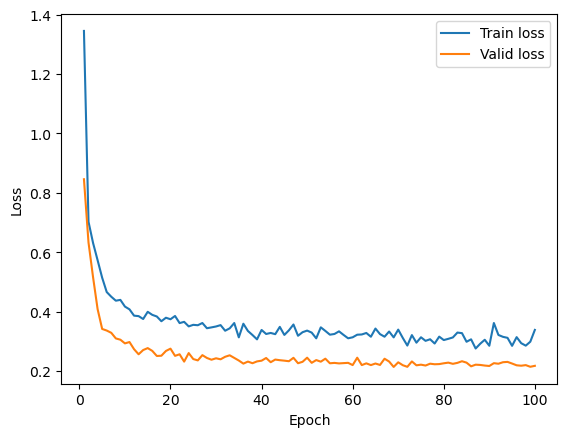

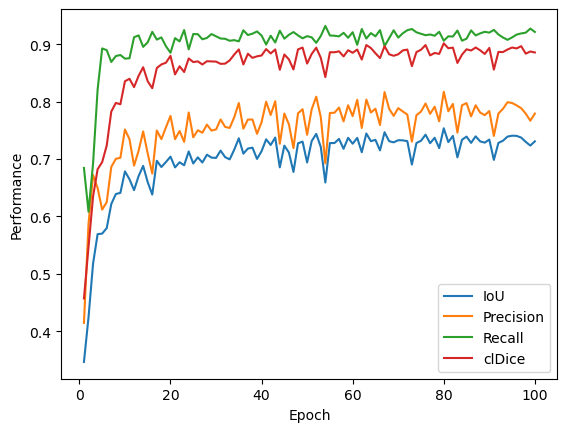

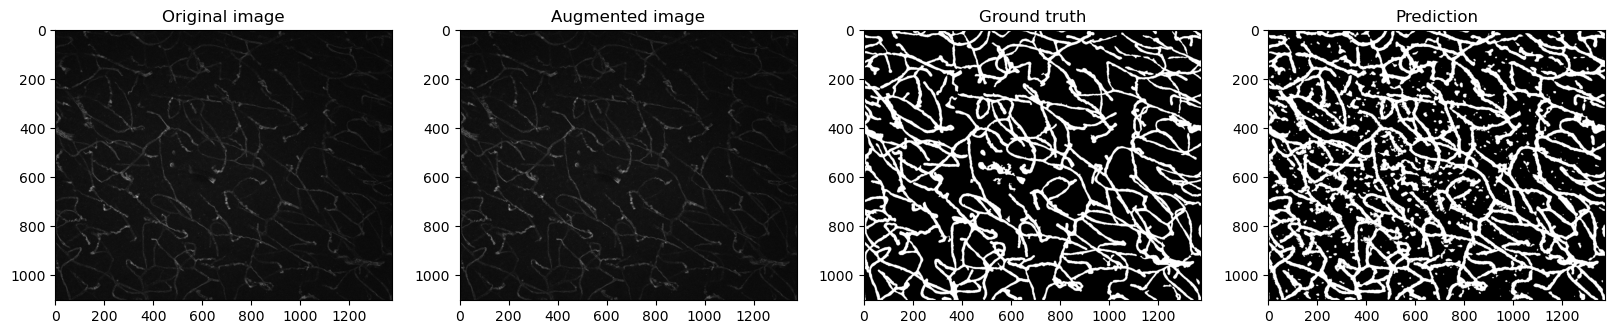

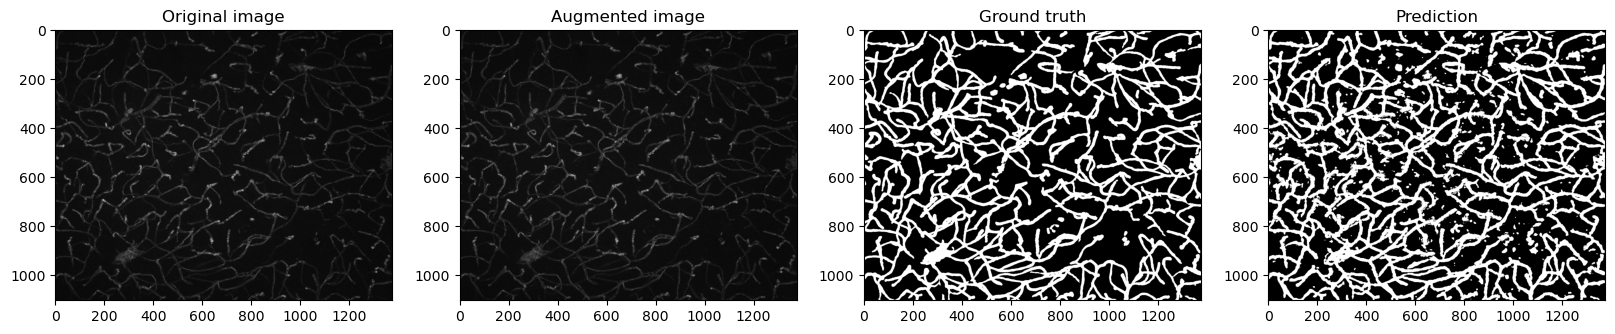

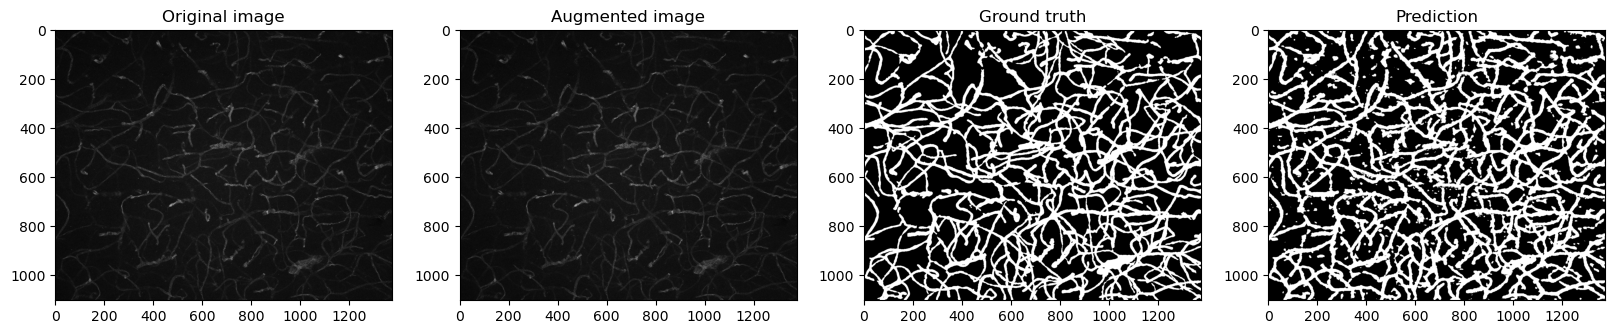

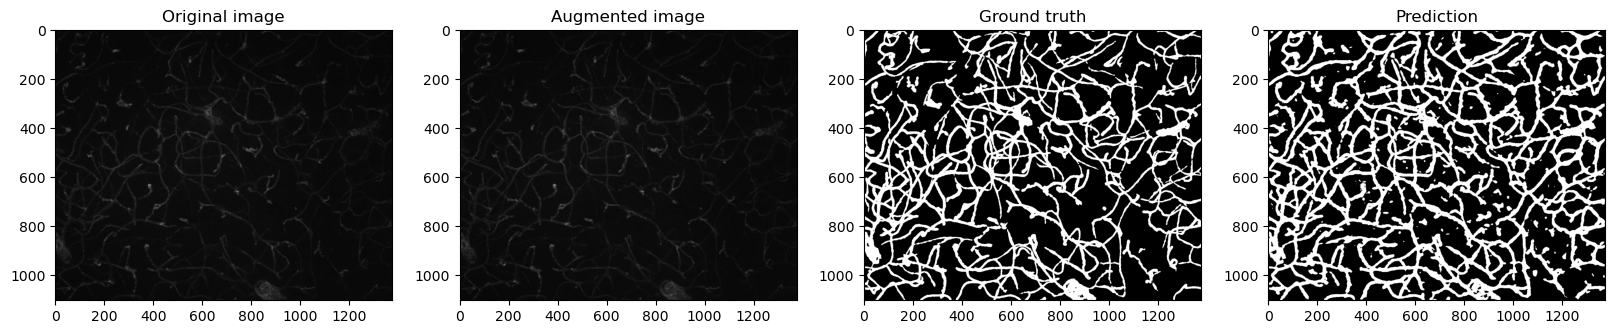

In [5]:
# Plot results
def plot_metrics(logger, type='lt'):
    '''Plot losses and IoU. `lt` is the logger used in Lightning.'''

    if type=='lt':
        metrics = logger.metrics
        epochs, _ = zip(*metrics['val_loss'])
        metrics = [list(zip(*metrics[k]))[1] for k in ['train_loss', 'val_loss', 'iou', 'prec', 
                                                       'rec', 'cldice']]
        train_loss, valid_loss, iou, prec, rec, cldice = metrics    
    elif type=='pt':
        epochs, metrics = zip(*logger.data.items())
        train_loss, valid_loss, iou, prec, rec, cldice = zip(*metrics)

    plt.figure()
    plt.plot(epochs, train_loss, label='Train loss')
    plt.plot(epochs, valid_loss, label='Valid loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.figure()
    plt.plot(epochs, iou, label='IoU')
    plt.plot(epochs, prec, label='Precision')
    plt.plot(epochs, rec, label='Recall')
    plt.plot(epochs, cldice, label='clDice')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Performance')

def plot_examples(ds, model, n=4):
    """Plot some example segmentations"""

    model.eval()
    model.cuda()
    indices = random.sample(range(len(ds)),n)
    for i, idx in enumerate(indices):
        x, y = ds[idx]
        x_or, y_or = ds.get_item(idx)
        with torch.no_grad():
            y_pred = model(x[None].cuda())[0].cpu()
        x = x[0]
        y_pred = torch.max(y_pred, dim=0)[1]

        plt.figure(figsize=[20,5])
        plt.subplot(1, 4, 1)
        plt.imshow(x_or, 'gray')
        plt.title('Original image')
        plt.subplot(1, 4, 2)
        plt.imshow(x, 'gray')
        plt.title('Augmented image')
        plt.subplot(1, 4, 3)
        plt.imshow(y, 'gray')
        plt.title('Ground truth')
        plt.subplot(1, 4, 4)
        plt.imshow(y_pred, 'gray')
        plt.title('Prediction')

plot_metrics(logger, type='pt')
plot_examples(ds_valid, model)

In [9]:
import numpy as np

keys = list(logger.data.keys())
valid_losses = []
for key in keys:
    valid_losses.append(logger.data[key][1])

best_key = keys[np.argmin(valid_losses)]
print(f'Valid loss:: {logger.data[best_key][1]}')
print(f'IoU: {logger.data[best_key][2]}')
print(f'clDice: {logger.data[best_key][5]}')

Valid loss:: 0.21354714035987854
IoU: 0.7291487455368042
clDice: 0.8800877332687378


In [11]:
best_key

69